# Goal

Train model

Thanks to: OBELISK, FAIMED3D, MONAI
- https://github.com/mattiaspaul/OBELISK
-  https://github.com/kbressem/faimed3d/blob/main/examples/3d_segmentation.md

# Setup parameters

In [1]:
# MODEL
model_type = "Regressor" #"SegResNetVAE" # "UNET3D" #"OBELISKHYBRID" #"VNET" # "UNET3D" "OBELISKHYBRID"
loss_type  = "mse_loss" #"vae_loss" #"perim_loss" #"log_cosh_dice_loss" # DICE

# DATALOADER PARAMS
bs          = 2
nepochs     = 300
num_workers = 2

# PREPROCESS (Isotropic, PadResize)
iso_sz    = 2
maxs      = [144, 144, 144]

# iso_sz    = 3
# maxs      = [96, 96, 96]

# Train:Valid:Test = 60:20:20
valid_frac, test_frac = .20, .20

# Setup paths

In [2]:
import os

# Paths to (1) code (2) data
code_src    = "/gpfs/home/gologr01"
data_src    = "/gpfs/data/oermannlab/private_data/DeepPit"

# stored code
deepPit_src = f"{code_src}/DeepPit"
obelisk_src = f"{code_src}/OBELISK"

# stored data
model_src   = f"{data_src}/saved_models"
label_src   = f"{data_src}/PitMRdata/samir_labels"
ABIDE_src   = f"{data_src}/PitMRdata/ABIDE"

# stored runs Tensorboard
run_src     = f"{data_src}/runs"

# print
print("Folders in data src: ", end=""); print(*os.listdir(data_src), sep=", ")
print("Folders in label src (data w labels): ", end=""); print(*os.listdir(label_src), sep=", ")
print("Folders in ABIDE src (data wo labels) ", end=""); print(*os.listdir(ABIDE_src), sep=", ")

Folders in data src: saved_landmarks, saved_models, sample_other_dsets, Labels, saved_dset_metadata, runs, saved_preds, PitMRdata
Folders in label src (data w labels): 50155-50212, PPMI_3107-3326, 50313-50372, 50213-50312, 50373-50453, 50002-50153, AIBL_2-263, ICMB_1005-1297, ADNI1_002_0023, ABVIB_49_235
Folders in ABIDE src (data wo labels) PAD, ABIDE_1, ABIDE


# Imports

In [3]:
# %load_ext autoreload
# %autoreload 2

In [4]:
# imports (# Piece)
from transforms import AddChannel, Iso, PadSz,\
                       ZScale, \
                       GNoise, GBlur,\
                       RandBright, RandContrast, \
                       RandDihedral, MattAff
        
        
from helpers.losses import dice, dice_score, dice_loss, dice_ce_loss, log_cosh_dice_loss, perim_loss

# MONAI
from monai.losses        import DiceLoss
from monai.metrics       import DiceMetric
from monai.networks.nets import VNet, UNet, SegResNetVAE, HighResNet, UNETR, Regressor

# Utilities
import os, sys, gc, time, pickle
from pathlib import Path

# Input IO
import SimpleITK as sitk
import meshio

# Numpy and Pandas
import numpy as np
import pandas as pd
from pandas import DataFrame as DF

# Fastai + distributed training
from fastai              import *
from fastai.torch_basics import *
from fastai.basics       import *
from fastai.distributed  import *
from fastai.callback.all import SaveModelCallback, CSVLogger

# PyTorch
from torch import nn

# Obelisk
sys.path.append(deepPit_src)
sys.path.append(obelisk_src)

# OBELISK
from utils  import *
from models import obelisk_visceral, obeliskhybrid_visceral

# Helper functions
from helpers.preprocess import get_data_dict_n4, mask2bbox, print_bbox, get_bbox_size, print_bbox_size, batch_get_bbox
from helpers.general    import sitk2np, np2sitk, print_sitk_info, lrange, lmap, numbers2groups, print_hardware_stats
from helpers.viz        import viz_axis, viz_compare_inputs, viz_compare_outputs
from helpers.time       import time_one_batch, get_time_id

# Data

In [5]:
folders = sorted(Path(label_src).iterdir(), key=os.path.getmtime, reverse=True)
# print(*[Path(f).name for f in folders], sep="\n")

cross_lbl_folders = folders[:5]
abide_lbl_folders = folders[5:]

print("Cross", *cross_lbl_folders, sep="\n"); print("*"*50)
print("Abide", *abide_lbl_folders, sep="\n")

Cross
/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/PPMI_3107-3326
/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/ICMB_1005-1297
/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/AIBL_2-263
/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/ADNI1_002_0023
/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/ABVIB_49_235
**************************************************
Abide
/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50373-50453
/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50313-50372
/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50213-50312
/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50155-50212
/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50002-50153


In [6]:
# Get data dict
data = {}
folders = abide_lbl_folders
for folder in folders: data.update(get_data_dict_n4(folder))

# Convert data dict => items (path to MR, path to Segm tensor)
items = list(data.values())
print(f"Full: {len(items)}")

Full: 335


In [7]:
# remove bad label 50132
weird_lbls = [50132, 50403]
def is_weird(fn): return any([str(lbl) in fn for lbl in weird_lbls])
   
items = [o for o in items if not is_weird(o[0])]
print(f"Removed {len(weird_lbls)} weird, new total: {len(items)}")

Removed 2 weird, new total: 333


# Split train/valid/test split

In [8]:
# save test set indices
with open(f"{data_src}/saved_dset_metadata/split_train_valid_test.pkl", 'rb') as f:
    train_idxs, valid_idxs, test_idxs, train_items, valid_items, test_items = pickle.load(f)
    tr_len, va_len, te_len =  len(train_items), len(valid_items), len(test_items)
    print("train, valid, test", tr_len, va_len, te_len, "total", tr_len + va_len + te_len)

train, valid, test 201 66 66 total 333


In [9]:
# items = items[:30]

# length  = len(items)
# indices = np.arange(length)
# np.random.shuffle(indices)
# #rank0_first(lambda: np.random.shuffle(indices))

# test_split   = int(test_frac  * length)
# valid_split  = int(valid_frac * length) + test_split

# test_idxs    = indices[:test_split] 
# valid_idxs   = indices[test_split:valid_split]
# train_idxs   = indices[valid_split:]

# train_items = [items[i] for i in train_idxs]
# valid_items = [items[i] for i in valid_idxs]
# test_items  = [items[i] for i in test_idxs]

# # print
# print(f"Total  {len(items)} items in dataset.")
# print(f"Train: {len(train_items)} items.")
# print(f"Valid: {len(valid_items)} items.")
# print(f"Test:  {len(test_items)} items.")

In [10]:
# # save test set indices
# with open(f"{data_src}/saved_dset_metadata/split_train_valid_test.pkl", 'wb') as f:
#     pickle.dump([train_idxs, valid_idxs, test_idxs, train_items, valid_items, test_items], f)

# Transforms

In [11]:
p = 0.8

# removed MattAff(p=p, strength=0.05)

item_tfms  = [Iso(iso_sz), PadSz(maxs)]
batch_tfms = [ZScale(), AddChannel(), MattAff(p=p, strength=0.05)]

# batch_tfms = [
#     # normalize mean/std of foreground pixels
#     ZScale(),
#     # flip
#     RandDihedral(p=p),
#     # noise
#     GNoise(p=p, std_range=[0.01, 0.1]),
#     #GBlur(p=p,  kernel_size_range=[5, 11], sigma=0.5),
#     AddChannel(),
#     # affine
#     MattAff(p=p, strength=0.05)
# ]

# Dataloaders

In [12]:
 # tls, dls, cuda
tls = TfmdLists(items, item_tfms, splits=(train_idxs, valid_idxs))
dls = tls.dataloaders(bs=bs, after_batch=batch_tfms, num_workers=num_workers)
dls = dls.cuda()

In [13]:
# test get one batch
# time_one_batch(dls)

# Model

In [14]:
full_res = maxs
print(f"Full res: {full_res}")

Full res: [144, 144, 144]


In [15]:
device = torch.device("cuda:0")
model = Regressor(
    in_shape   = (1,*full_res), 
    out_shape  = (3), 
    channels   = (16, 32, 64, 128, 256),
    strides    = (2, 2, 2, 2), 
    kernel_size=3, 
    num_res_units=2, 
    act='PRELU', 
    norm='INSTANCE', 
    dropout=None, 
    bias=True
).to(device)

# Loss

In [16]:
# xb,yb = dls.one_batch()
# predb = model(xb)
# bboxs = batch_get_bbox(yb)

In [17]:
# for i in range(len(yb)):
#     print(mask2bbox(np.asarray(yb[i].cpu().squeeze())))
    
# # convert to probs
# zeros = torch.where(yb == 1, 0, 1)
# probs = torch.cat((zeros, yb),dim=1)
# bboxs = [tuple([a.item() for a in bbox]) for bbox in bboxs]
# for i in range(len(yb)):
#     print(bboxs[i])

In [18]:
# # bbox2mask
# def bbox2mask(bbox, sz=full_res):
#     # float bbox -> integer
#     a,b,c,d,e,f = torch.round(bbox).int()
#     arr = torch.zeros(full_res)
#     arr[a:b, c:d, e:f] = 1
#     return arr

In [19]:
# # metric
# def dice_score_regression(preds, targets):
#     pred_masks = torch.stack([bbox2mask(bbox) for bbox in preds], dim=0).to(preds.get_device())
    
#     dice_loss = dice(pred_masks, targets.squeeze())
#     #loss = Variable(dice_loss, requires_grad = True)
#     return dice_loss

In [20]:
from fastai.losses import MSELossFlat

In [57]:
def sigmoid_range(x, lo, hi): return torch.sigmoid(x) * (hi-lo) + lo

def mse_centroid_loss(preds, targets):
    preds = sigmoid_range(preds, lo=0, hi=full_res[0])
    targets = targets.squeeze() # BCDHW -> BDWH
    centroids = torch.stack([torch.nonzero(tgt).float().mean(dim=0) for tgt in targets], dim=0)
    return MSELossFlat()(preds, centroids)#/100.0 # scale it down

In [58]:
# # from fastai
# def sigmoid_range(x, lo, hi): return torch.sigmoid(x) * (hi-lo) + lo

# def mse_bin_mask_loss(preds, targets):
#     """
#     preds   = Bx6 coords
#     targets = BCDHW, where C = 1
#     -> target_bbox = Bx6
#     -> preds scaled to be [0,144]
#     -> MSE(preds, target_bbox)
#     """
#     # get bbox B x (imin imax jmin jmax kmin kmax)
#     target_bbox = batch_get_bbox(targets).to(targets.get_device())
    
#     # scale preds between 0-size
#     preds = sigmoid_range(preds, lo=0, hi=full_res[0])

#     # print debug
#     #print(target_bbox.dtype, preds.dtype)
    
# #     print("Preds: ", preds)
# #     print("Target bbox: ", target_bbox)
# #     print(f"MSE: {torch.nn.MSELoss()(preds.float(), target_bbox.float()):.2f}")
          
#     # get MSE between prediction and target bbox
#     return torch.nn.MSELoss(reduction='sum')(preds.float(), target_bbox.float())

In [59]:
# mse_bin_mask_loss(predb, yb)

In [60]:
if loss_type == "log_cosh_dice_loss":
    loss_function = log_cosh_dice_loss
elif loss_type == "DICE":
    loss_function = dice_loss
    
elif loss_type == "perim_loss":
    loss_function = log_cosh_dice_loss
    #loss_function = perim_loss
    
elif loss_type == "vae_loss":
    loss_function = vae_loss
    
elif loss_type == "mse_loss":
    loss_function = mse_centroid_loss
else:
    loss_function = DiceLoss(to_onehot_y=False, sigmoid=True, squared_pred=False)

In [61]:
# Save test idxs + model + runs

# file name
model_time = rank0_first(lambda:get_time_id()) # 'Mon Oct 18 13:35:29 2010'
model_name = f"model_{model_type}_loss_{loss_type}_iso_{iso_sz}mm_pad_{maxs[0]}_{maxs[1]}_{maxs[2]}_bs_{bs}_epochs_{nepochs}_time_{model_time}"
print(f"Model name: {model_name}")

Model name: model_Regressor_loss_mse_loss_iso_2mm_pad_144_144_144_bs_2_epochs_300_time_1627072951_Fri_Jul_07_2021_hr_16_min_42


# Save

In [62]:
# make dir
model_src = f"{run_src}/{model_name}"
fig_src = f"{model_src}/figs"
Path(fig_src).mkdir(parents=True, exist_ok=True)

# Metrics & Callbacks

In [63]:
if model_type == "Regressor":
    metrics = []# [dice_score_regression]
    cbs = [SaveModelCallback(monitor='valid_loss', with_opt=True), CSVLogger(fname=f"{fig_src}/history.csv")]
else:
    metrics = [dice_score]
    cbs = [SaveModelCallback(monitor='dice_score', with_opt=True), CSVLogger(fname=f"{fig_src}/history.csv")]

In [64]:
class PerimLossMidway(Callback):
    def before_epoch(self): 
        if self.epoch == self.n_epoch//2:
            self.learn.loss_func = perim_loss
            print("Changed ", self.learn.loss_func, "at epoch ", self.n_epoch//2)    
            
if loss_type == "perim_loss":
    print("added PerimLoss callback")
    cbs.append(PerimLossMidway())
    

In [65]:
# save test set indices
with open(f"{model_src}/test_items.pkl", 'wb') as f:
    rank0_first(lambda:pickle.dump(list(test_items), f))
   
# save data augs
with open(f"{model_src}/data_augs.txt", 'w') as f:
    s = "\n".join([model_name] + [str(tfm) for tfm in item_tfms + batch_tfms])
    rank0_first(lambda: print(s, file=f))
    
# with open(f"{model_src}/{model_name}_test_items.pkl", 'wb') as f:
#     rank0_first(lambda:pickle.dump(list(test_items), f))

# Learner

In [66]:
# clear cache
gc.collect()
torch.cuda.empty_cache()
print_hardware_stats()

#GPU = 2, #CPU = 40
GPU Tesla V100-SXM2-16GB RAM Free: 14860MB | Used: 1300MB | Util   8% | Total 16160MB
GPU Tesla V100-SXM2-16GB RAM Free: 16157MB | Used: 3MB | Util   0% | Total 16160MB


In [67]:
learn = rank0_first(lambda:
            Learner(dls   = dls, \
                model     = model, \
                loss_func = loss_function, \
                metrics   = metrics, \
                model_dir = model_src, \
                cbs       = cbs)
        )

# cbs TensorBoardCallback(Path(run_src)/model_name, trace_model=True)
# GPU
learn.model = rank0_first(lambda:learn.model.cuda())

In [68]:
# sz: 144 -> 72 -> 36 -> 18 -> 9 -> 6
# ft: 16 -> 32 -> 64 -> 128 -> 256
# print(learn.summary())

In [69]:
# # check
# print("Check")
# b = dls.one_batch()
# xb,yb = b
# print(f"Batch: {len(b)}. xb: {xb.shape}, yb: {yb.shape}")
# predb = learn.model(xb)
# print(f"Pred batch: {predb.shape}")
# loss = learn.loss_func(predb, yb)
# print(f"Loss: {loss}")

In [70]:
# print(predb[0].shape, predb[1])

# LR Finder

In [71]:
# print("PRE learn.fit one cycle")
# with learn.distrib_ctx():
#     learn.fit_one_cycle(2, 3e-3, wd = 1e-4)

SuggestedLRs(valley=tensor(8.3176e-06))

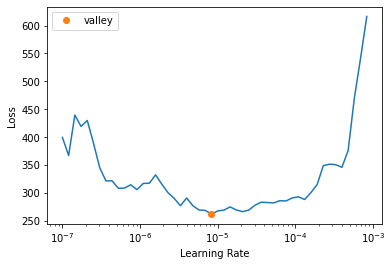

In [72]:
# learn.lr_find() SuggestedLRs(valley=tensor(8.3176e-06))
# SuggestedLRs(valley=tensor(1.2023e-05))
# SuggestedLRs(valley=tensor(1.4454e-05))

In [53]:
print(f"nepochs {nepochs}")

nepochs 300


In [ ]:
print("PRE learn.fit one cycle")

with learn.distrib_ctx():
    learn.fit_one_cycle(nepochs, 1e-5, wd = 1e-4)
    #learn.fit_one_cycle(nepochs, 3e-3, wd = 1e-4)
    #learn.fit_one_cycle(nepochs, 6e-5, wd = 1e-4)
    

PRE learn.fit one cycle


epoch,train_loss,valid_loss,time
0,201.828629,193.827011,00:52
1,181.950607,186.774170,00:43
2,165.299515,178.430573,00:41
3,153.802505,177.824448,00:42
4,164.742386,180.345886,00:43
5,163.094727,165.814667,00:42
6,154.069778,152.792999,00:41
7,143.254898,163.348709,00:43
8,145.322433,160.146210,00:43
9,136.471069,155.120651,00:42


Better model found at epoch 0 with valid_loss value: 193.82701110839844.
Better model found at epoch 1 with valid_loss value: 186.774169921875.
Better model found at epoch 2 with valid_loss value: 178.43057250976562.
Better model found at epoch 3 with valid_loss value: 177.82444763183594.
Better model found at epoch 5 with valid_loss value: 165.81466674804688.
Better model found at epoch 6 with valid_loss value: 152.79299926757812.
Better model found at epoch 10 with valid_loss value: 139.6387481689453.
Better model found at epoch 11 with valid_loss value: 137.15536499023438.
Better model found at epoch 13 with valid_loss value: 131.06568908691406.
Better model found at epoch 16 with valid_loss value: 129.18948364257812.
Better model found at epoch 18 with valid_loss value: 115.94245147705078.
Better model found at epoch 19 with valid_loss value: 109.44892120361328.
Better model found at epoch 22 with valid_loss value: 103.54600524902344.
Better model found at epoch 28 with valid_loss 

In [ ]:
#     if loss_type == "perim_loss":
#         learn.loss_func = perim_loss
#         print("switched loss at epoch ", nepochs//2)
    
#     learn.fit_one_cycle(nepochs//2, 3e-3, wd = 1e-4)

In [ ]:
# learn.recorder.plot_loss()

In [ ]:
def save_plot_loss(self, skip_start=5, with_valid=True):
        plt.plot(list(range(skip_start, len(self.losses))), self.losses[skip_start:], label='train')
        if with_valid:
            idx = (np.array(self.iters)<skip_start).sum()
            plt.plot(self.iters[idx:], L(self.values[idx:]).itemgot(1), label='valid')
            plt.legend()
        plt.savefig(f'{fig_src}/loss.png', bbox_inches='tight')
        plt.close()

In [ ]:
# save_plot_loss(learn.recorder)

In [ ]:
@delegates(subplots)
def save_plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
    #plt.show()
    plt.savefig(f'{fig_src}/metrics.png', bbox_inches='tight')
    plt.close()

In [ ]:
save_plot_metrics(learn.recorder)

# Old

In [ ]:
# batch_tfms = [
#     # normalize mean/std of foreground pixels
#     ZScale(),
#     # affine + flips
#     RandomAffine(p=0.5, degrees=35, translate=0.1, scale=0.1),
#     RandDihedral(p=0.5),
#     # lighting
#     RandBright(p=0.5),
#     RandContrast(p=0.5),
#     # noise for generalizability
#     GNoise(p=0.5),
#     GBlur(p=0.5),
#     # add channel dim
#     AddChannel()

# UMich 
# code src: "/home/labcomputer/Desktop/Rachel"
# data src: "../../../../..//media/labcomputer/e33f6fe0-5ede-4be4-b1f2-5168b7903c7a/home/rachel/"

# ]

# Test

In [ ]:
# print("Test")
# xb, yb = dls.one_batch()
# xb, yb = xb.cpu(), yb.cpu()

# pb = model.cpu()(xb)
# print(xb.shape, pb.shape)
# print(f"logcosh dice loss {log_cosh_dice_loss(pb,yb)}")

In [ ]:
# # test:

# #dls.device = "cpu"

# start = time.time()

# x,y = dls.one_batch()
# #x,y = to_cpu(x), to_cpu(y)

# pred = learn.model(x)
# loss = learn.loss_func(pred, y)

# elapsed = time.time() - start

# print(f"Elapsed: {elapsed} s")
# print("Batch: x,y")
# print(type(x), x.shape, x.dtype, "\n", type(y), y.shape, y.dtype)

# print("Pred shape")
# print(type(pred), pred.shape, pred.dtype)

# print("Loss")
# print(loss)
# print(learn.loss_func)